This notebook may be used in Google Colab. To access press this button:    
<a href="https://bit.ly/deap-knapsack-colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>


# `DEAP` as a Prototyping Tool

<img src="https://deap.readthedocs.io/en/master/_images/deap_long.png" width=300>


> `DEAP` is a novel evolutionary computation framework for rapid prototyping and testing of ideas. It seeks to make algorithms explicit and data structures transparent. It works in perfect harmony with parallelisation mechanism such as multiprocessing and `SCOOP`. 

`DEAP` contains numerous concepts and many features to build your own evolutions.

[`DEAP` Documentation](https://deap.readthedocs.io/en/master/)

Here we demo its use to solve for the Knapsack problem

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg" width=250>


For the most part we follow thier [Knapsack tutorial](https://deap.readthedocs.io/en/master/examples/ga_knapsack.html), in which the individual knapsacks inherite from `set`s. 

<img src="https://tinyurl.com/vrdj29w9" width="700">  

**One final note for PyCon USA participants**  

Don't worry if you don't manage to to go through everything in depth during the allocated time. You will be able to access to this notebook later.

In [1]:
# Let's first verify that we have DEAP setup 

try:
    from deap import creator
except:
    %pip install deap

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Packages

Let's create some data!

<img src="https://uk.packsize.com/wp-content/uploads/sites/11/2015/05/wp-boxes.jpg" width=300>


Here we generate `n_packages` packages and assign each a weight and monetary value. 

In [4]:
n_packages = 300

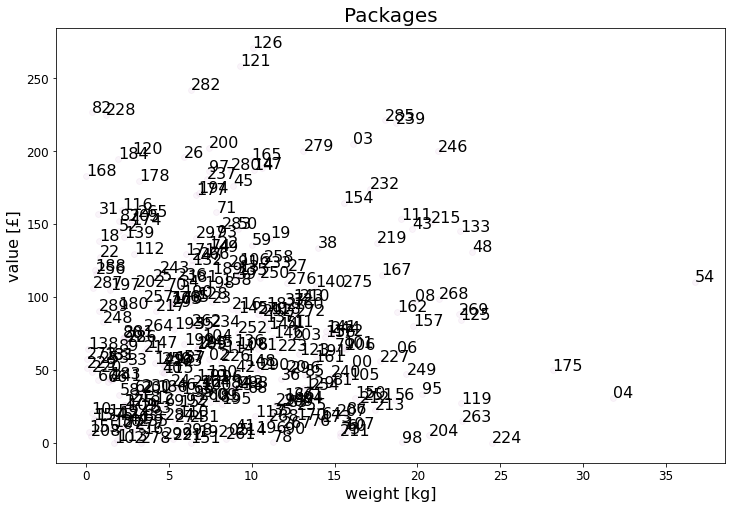

In [5]:
def visualise_packages(packages):
    plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
                [packages[idx_package]['value'] for idx_package in packages],
                color = 'purple', alpha=0.04
               )

    for idx_package, package in packages.items():
        plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title('Packages')

def generate_packages(n_packages = 20, 
                      weight_mean = 0.1, weight_sd = 10,
                      value_mean = 0.1, value_sd = 100,
                      value_distribution_mode = 'random',
                      noise_factor = 1./2,
                      seed = 3141592653, visualise=True):
    """
    n_packages: int. the total number of packages to choose from
    weight_mean: float. the mean of the weight distribution
    weight_sd: float. the standard deviation of the weight distribution
    value_mean: float. when value_distribution_mode='random': the mean of the monetary 
    value_distribution_mode: str. (default: 'random', 'squared')
    noise_factor: float. when value_distribution_mode='squared': the standard deviation of the noise introduced
    """

    np.random.seed(seed)

    weights = np.abs(np.random.normal(weight_mean, weight_sd, n_packages))

    if 'squared' == value_distribution_mode:
        values =  weights ** 2 
        values += values * np.random.normal(0, noise_factor, len(weights))
        values = np.abs(values)
    elif 'random' == value_distribution_mode:
        values = np.abs(np.random.normal(value_mean, value_sd, n_packages))
        
    packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(n_packages)}
    
    if visualise:
        visualise_packages(packages)

        
    return packages

packages = generate_packages(n_packages, value_distribution_mode="random")

# `DEAP` Setup

`DEAP` provides multiple tools for the evolutionary setup and processing.

In [6]:
from deap import creator
from deap.base import Fitness, Toolbox
from deap.tools import (
    initRepeat, 
    ParetoFront,
    Statistics,
    selNSGA2,
    selSPEA2
)
from deap.algorithms import eaMuPlusLambda 
import random

## Objectives via Fitness 

> The provided `Fitness` class is an abstract class that needs a weights attribute in order to be functional. A minimizing fitness is built using negatives weights, while a maximizing fitness has positive weights. For example, the following line creates, in the creator, a ready to use single objective minimizing fitness named FitnessMin.

Single Objective Optimisation
```python
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
```

Multi-Objective Optimisation
```python
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
```

`weights`: `-1` is for minmising and `1` is for maximising

> The weights can also be used to vary the importance of each objective one against another. This means that the weights can be any real number and only the sign is used to determine if a maximization or minimization is done. An example of where the weights can be useful is in the crowding distance sort made in the NSGA-II selection algorithm.

[DEAP Documentation](https://deap.readthedocs.io/en/master/tutorials/basic/part1.html#fitness)


In [7]:
# Creating a class called `Fitness` 

# In our order here we minimise weight and maximise monetary value
creator.create("Fitness", Fitness, weights=(-1.0, 1.0))


## Individuals and Populations

Each solution is considered an *Individual* and has its fitness compared to counterparts collectively called the *Population*.  




<img src="https://www.chatelaine.com/wp-content/uploads/2019/07/5-most-popular-backpacks-feature.jpg" width=500>



For additional information about inheritence from numpy see [DEAP documentation](https://deap.readthedocs.io/en/master/tutorials/advanced/numpy.html)


In our case we will create the knapsacks each with up to `n_packages_per_knapsack` packages.

In [8]:
n_packages_per_knapsack = 50

In [9]:
# Creating a class called `Individual` which inherites from set

creator.create("Individual", set, fitness=creator.Fitness)
#creator.create("Individual", np.ndarray, fitness=creator.Fitness)

Creation of and operation on individuals is conducted within the `Toolbox`.

> A toolbox for evolution that contains the evolutionary operators. At first the toolbox contains a `clone()` method that duplicates any element it is passed as argument, this method defaults to the `copy.deepcopy()` function. and a `map()` method that applies the function given as first argument to every items of the iterables given as next arguments, this method defaults to the `map()` function. You may populate the toolbox with any other function by using the `register()` method.


[DEAP documentation](https://deap.readthedocs.io/en/master/api/base.html?highlight=toolbox#toolbox)

In [10]:
toolbox = Toolbox()

In [11]:
# item_id : package (as in: an item in a knapsack) - (instead of attr_item)

toolbox.register("item_id", random.randrange, n_packages)


print(f"toolbox.item_id selects package id,\ne.g, {toolbox.item_id()}")

toolbox.item_id selects package id,
e.g, 21


In [12]:
# individual: knapsack

toolbox.register("individual", initRepeat, creator.Individual, 
                 toolbox.item_id, n_packages_per_knapsack)

print(f"toolbox.individual generates a knapsack from package_ids,\ne.g, {toolbox.individual()}")

toolbox.individual generates a knapsack from package_ids,
e.g, Individual({256, 129, 131, 132, 263, 264, 266, 143, 17, 147, 24, 27, 285, 287, 33, 293, 165, 296, 40, 298, 172, 179, 183, 57, 186, 58, 61, 189, 197, 198, 208, 84, 89, 219, 93, 226, 227, 229, 103, 107, 108, 112, 113, 242, 121, 123, 124})


In [13]:
# population: population of knapsacks

toolbox.register("population", initRepeat, list, toolbox.individual)

n_display = 3
print(f"toolbox.population generating a population of {n_packages} knapsacks from package_ids,\ne.g, here we examine the first {n_display}\n{toolbox.population(n_packages)[:n_display]}")

toolbox.population generating a population of 300 knapsacks from package_ids,
e.g, here we examine the first 3
[Individual({128, 2, 259, 133, 6, 261, 263, 138, 140, 13, 14, 147, 20, 150, 279, 152, 281, 156, 285, 36, 164, 169, 42, 43, 176, 177, 52, 182, 184, 186, 187, 63, 192, 72, 74, 203, 75, 206, 82, 86, 87, 218, 223, 97, 232, 112, 116}), Individual({256, 129, 3, 4, 261, 134, 135, 8, 137, 9, 13, 16, 277, 24, 281, 159, 290, 291, 294, 40, 297, 173, 175, 49, 183, 60, 190, 67, 70, 74, 77, 79, 208, 207, 211, 216, 219, 225, 233, 250, 239, 115, 244, 248, 122, 252, 125}), Individual({128, 257, 130, 132, 6, 263, 8, 136, 265, 274, 150, 23, 26, 282, 30, 162, 38, 166, 295, 296, 45, 176, 51, 54, 184, 185, 59, 63, 65, 197, 200, 75, 78, 208, 84, 213, 86, 217, 218, 222, 96, 228, 100, 239, 116, 118, 120, 254, 255})]


# Custom Functions

## Evaluating Fitness

In [14]:
def eval_knapsack(individual):
    weight = 0.0
    value = 0.0
    for package_id in individual:
        weight += packages[package_id]["weight"]
        value += packages[package_id]["value"]
    #if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
    #    return 10000, 0             # Ensure overweighted bags are dominated
    return weight, value


indv = toolbox.individual()
indv_fitness = eval_knapsack(indv)

print(f"The fitness (weight, monetary value) of knapsack {indv}\nis: \n{indv_fitness}")

The fitness (weight, monetary value) of knapsack Individual({2, 259, 134, 135, 8, 136, 266, 274, 148, 276, 287, 37, 293, 40, 168, 178, 51, 52, 54, 183, 58, 66, 70, 204, 81, 83, 84, 211, 86, 216, 90, 230, 103, 232, 233, 235, 108, 110, 240, 124, 115, 119, 121, 252})
is: 
(399.7691145644986, 3143.1473535823684)


## Transformations

### Crossover

Here we use a different crossover from previous notebooks:

`child1` gets that `parent1` and `parent2` overlap: `child1 = parent1 & parent2`

`child2` gets their difference: `child2 = parent1 ^ parent2`


Note: the `VarOr` algorithm below uses only `child1` as and offspring and disregards `child2`.

In [15]:
def crossover_set(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    temp = set(ind1)                # Used in order to keep type
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Symmetric Difference (inplace)
    return ind1, ind2

parent1, parent2 = toolbox.individual(), toolbox.individual()
print(f"parent 1:\n{parent1}")
print(f"parent 2:\n{parent2}")
print(f"parent overlap:\n{set(parent1) & set(parent2)}")
print("-" * 20)


child1, child2 = crossover_set(parent1, parent2)

print(f"child 1:\n{child1}")
print(f"child 2:\n{child2}")
print(f"children overlap:\n{set(child1) & set(child2)}")

parent 1:
Individual({256, 260, 6, 7, 264, 266, 10, 11, 270, 274, 278, 151, 24, 25, 26, 286, 160, 34, 291, 35, 37, 295, 168, 41, 42, 172, 177, 50, 189, 63, 72, 77, 81, 84, 212, 87, 95, 99, 102, 233, 108, 242, 115, 244, 250, 123})
parent 2:
Individual({9, 138, 141, 14, 270, 145, 273, 20, 21, 22, 280, 155, 159, 162, 292, 293, 296, 170, 45, 175, 187, 60, 192, 67, 196, 69, 198, 70, 73, 74, 203, 204, 80, 208, 210, 83, 86, 216, 217, 88, 89, 222, 104, 108, 238, 111, 251, 255})
parent overlap:
{108, 270}
--------------------
child 1:
Individual({108, 270})
child 2:
Individual({6, 7, 9, 10, 11, 14, 20, 21, 22, 24, 25, 26, 34, 35, 37, 41, 42, 45, 50, 60, 63, 67, 69, 70, 72, 73, 74, 77, 80, 81, 83, 84, 86, 87, 88, 89, 95, 99, 102, 104, 111, 115, 123, 138, 141, 145, 151, 155, 159, 160, 162, 168, 170, 172, 175, 177, 187, 189, 192, 196, 198, 203, 204, 208, 210, 212, 216, 217, 222, 233, 238, 242, 244, 250, 251, 255, 256, 260, 264, 266, 273, 274, 278, 280, 286, 291, 292, 293, 295, 296})
children overl

### Mutations

In the original demo they mutate only one package.  
Perhaps in a future version we can mutate more than one to get larger diversity.



In [16]:
# this is the function that we will use later one
def mutate_set(individual):
    """Mutation that pops or add an element."""
    if random.random() < 0.5:
        if len(individual) > 0:     # We cannot pop from an empty set
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(n_packages))
    return individual,

knapsack3 = toolbox.individual()
print(f"original:\n{knapsack3}")
child3 = mutate_set(knapsack3)
print(f"\nmutated:\n{child3[0]}")
print(f"\ndifference:\n{child3[0] ^ knapsack3}")

original:
Individual({131, 259, 132, 263, 138, 11, 140, 14, 143, 15, 20, 149, 24, 29, 32, 291, 38, 295, 41, 169, 48, 178, 61, 191, 192, 65, 193, 63, 69, 70, 197, 203, 78, 209, 211, 212, 85, 87, 94, 224, 105, 107, 236, 112, 244, 245, 250, 251})

mutated:
Individual({131, 259, 132, 263, 138, 11, 140, 14, 143, 15, 20, 149, 24, 29, 32, 291, 38, 295, 41, 169, 48, 178, 61, 191, 192, 65, 193, 63, 69, 70, 197, 203, 78, 207, 209, 211, 212, 85, 87, 94, 224, 105, 107, 236, 112, 244, 245, 250, 251})

difference:
set()


In [17]:
# for displaying purposes
# reason: here we use the toolbox.clone so we can actually 
#         see a difference between child3 and knapsack3
#         I'm not sure why this is not apparent when not cloned
# In the actual run the toolbox.clone is performed in the `varOr` function

def mutate_set_hack(individual):
    """Mutation that pops or add an element."""
    mutated = toolbox.clone(individual)
    if random.random() < 0.5:
        if len(mutated) > 0:     # We cannot pop from an empty set
            mutated.remove(random.choice(sorted(tuple(mutated))))
    else:
        mutated.add(random.randrange(n_packages))
    return mutated,

knapsack4 = toolbox.individual()
print(f"original:\n{knapsack4}")
child4 = mutate_set_hack(knapsack4)
print(f"\nmutated:\n{child4[0]}")
print(f"\ndifference:\n{child4[0] ^ knapsack4}")

original:
Individual({257, 131, 4, 5, 263, 140, 13, 12, 271, 15, 141, 272, 275, 147, 276, 153, 155, 286, 161, 165, 40, 170, 46, 47, 48, 56, 189, 195, 68, 199, 204, 77, 81, 82, 84, 88, 224, 97, 99, 233, 115, 117, 249, 122, 251, 252, 125})

mutated:
Individual({257, 131, 4, 5, 263, 140, 13, 12, 271, 15, 141, 272, 275, 147, 276, 143, 153, 155, 286, 161, 165, 40, 170, 46, 47, 48, 56, 189, 195, 68, 199, 204, 77, 81, 82, 84, 88, 224, 97, 99, 233, 115, 117, 249, 122, 251, 252, 125})

difference:
{143}




We now register all of the custom functions into the `Toolbox`. 

In [18]:
toolbox.register("evaluate", eval_knapsack)
toolbox.register("mate", crossover_set)
toolbox.register("mutate", mutate_set)

## Selection Function

Getting the bleeding edge Pareto Front Evolutionary Algorithms is one of the main reason to use packages like `DEAP`. 

Here we imported 
* `selSPEA2`
* `selNSGA2`   
and need to choose between them. 

This sort of decision is beyond the scope of this tutorial, so for the time being, consider them practically equilvalent. There is a lot of literature on this topic, if you would like to learn more.

> "There can be ~only~ [$\ge$] one!").  


<img src="https://i.ytimg.com/vi/Oc9fUbjJbAU/maxresdefault.jpg" width=300>


In [19]:
toolbox.register("select", selSPEA2)

# Running Evolution

<img src="https://i.pinimg.com/originals/1a/5c/a8/1a5ca8373a83e8e84f8f268ee3ecf1de.png" width=400>

The main algorithm for evolution is  `eaMuPlusLambda` algorithm (𝜇+𝜆) evolutionary algorithm, where:  
* 𝜇 - The number of individuals to select for the next generation.
* 𝜆 - The number of children to produce at each generation.


([documentation](https://deap.readthedocs.io/en/master/api/algo.html), [Github](https://github.com/DEAP/deap/blob/master/deap/algorithms.py#L248))

```python
evaluate(population)
for g in range(ngen):
    offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)
    evaluate(offspring)
    population = select(population + offspring, mu)
```

Here we use the `VarOr` algorithm.

> Part of an evolutionary algorithm applying only the variation part (crossover, mutation or reproduction). The modified individuals have their fitness invalidated. The individuals are cloned so returned population is independent of the input population.


Below we provide the full script, where the following is the main part:

```python
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = map(toolbox.clone, random.sample(population, 2))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(random.choice(population))
```

Here we see:

* Each child is generated by either:
    * mating between two randomly selected parents (with replacement): `toolbox.mate` (note the waste - the second child is discarded)
    * OR mutation `toolbox.mutate`
    * OR reproduction (cloning)

([documentation](https://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.varOr), [Github](https://github.com/DEAP/deap/blob/master/deap/algorithms.py#L192))

## Hyper Parameters

In [20]:
MU = 50         # The number of individuals to select for the next generation.
LAMBDA = 100    # The number of children to produce at each generation.

In [21]:
# Other hyper parameters
NGEN = 100     # The stopping criterion: the number generations

CXPB = 0.7     # The probability that an individual is selected for mating
MUTPB = 0.3    # The probability that an individual is selected for mutation

Note:

Above we see that we have selected
* `CXPB` - The probability that an individual is selected for mating
* `MUTPB` - The probability that an individual is selected for mutation

Besides mating and mutating there is a third option for an individual: reproduction (i.e, to be cloned).   
* `1 - CXPB - MUTPB`   - The probablilty that an indiviaul is selected for reproduction (i.e, cloning)

In my experience, when `CXPB - MUTPB != 1` (i.e, we enable cloning) the diversity is substantially reduced, and so I set `CXPB - MUTPB = 1`.

In [22]:
def genetic_algorithm(verbose=False, hack=False):
    pop = toolbox.population(n=MU)
    hof = ParetoFront() # retrieve the best non dominated individuals of the evolution
    
    # Statistics created for compiling four different statistics over the generations
    stats = Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0) # axis=0: compute the statistics on each objective independently
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    
    if hack:
        _, logbook, all_generations = \
        eaMuPlusLambda_hack(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                                  halloffame=hof, verbose=verbose)

        return pop, stats, hof, logbook, all_generations
    else:
        _, logbook = \
        eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                                  halloffame=hof, verbose=verbose)

        return pop, stats, hof, logbook
        

pop, stats, hof, logbook = genetic_algorithm(hack=False)

In [23]:
print("statistics of the last generation population")
stats.compile(pop)

statistics of the last generation population


{'avg': array([ 159.94345621, 3476.43271917]),
 'std': array([ 121.55639097, 1956.09812596]),
 'min': array([0., 0.]),
 'max': array([ 375.79890587, 6570.9108529 ])}

In [24]:

print("statistics of the Hall of Fame (Pareto Front of all generations)")
stats.compile(hof)

statistics of the Hall of Fame (Pareto Front of all generations)


{'avg': array([ 151.85038982, 3377.73529851]),
 'std': array([ 115.38438974, 1852.05480611]),
 'min': array([0., 0.]),
 'max': array([ 375.79890587, 6570.9108529 ])}

In [25]:
generation = 0

print("Logbook of generation {generation}")

logbook[generation]

Logbook of generation {generation}


{'gen': 0,
 'nevals': 50,
 'avg': array([ 402.4910862 , 3531.06032513]),
 'std': array([ 34.41782852, 378.8449752 ]),
 'min': array([ 333.38154226, 2466.36105909]),
 'max': array([ 503.05645951, 4257.13374922])}

## Diversity

Some algorithms for meaningful insights of the population

In [26]:
def population_df(pop):
    pop_values = [np.sum([packages[package_id]["value"] for package_id in indv]) for indv in pop]
    pop_weights = [np.sum([packages[package_id]["weight"] for package_id in indv]) for indv in pop]

    df_population = pd.DataFrame({"value": pop_values, "weight": pop_weights})
    df_population = pd.DataFrame(df_population.groupby(["value", "weight"]).size(), columns=["counts"]).reset_index()
    df_population.index.name = "knapsack_id"

    #df_population.sort_values("counts", ascending=False)
    return df_population

In [27]:
df_population = population_df(pop)

print(df_population.shape)
df_population.sort_values("counts", ascending=False).head(4)

(50, 3)


,value,weight,counts
knapsack_id,,,
0,0.000000,0.000000,1
37,5183.881047,282.229028,1
27,3963.648493,155.527248,1
28,4131.815473,182.871776,1


In [28]:
# exploring the diversity of the objectives
# 1 - means unique
# 2 - means duplicated
# 3 - means tripled
# 4 ...
df_population["counts"].value_counts()

1    50
Name: counts, dtype: int64

Same thing but for the Hall of Fame.

In [29]:
df_hof = population_df(hof)

print(df_hof.shape)
display(df_population["counts"].value_counts())
df_hof.sort_values("counts", ascending=False).head(4)

(119, 3)


1    50
Name: counts, dtype: int64

,value,weight,counts
knapsack_id,,,
0,0.000000,0.000000,1
75,4354.786213,190.955625,1
87,4925.047354,237.595860,1
86,4770.435534,232.756098,1


## Visualising

In [30]:
def scatter_pop(pop, color="purple", label=None, marker="o"):
    df_population = population_df(pop)
    
    marker_size = 50 * df_population["counts"]
    plt.scatter(df_population["weight"], df_population["value"], marker=marker,s=marker_size, alpha=0.3, color=color, label=label) 

Text(0.5, 1.0, 'Knapsacks')

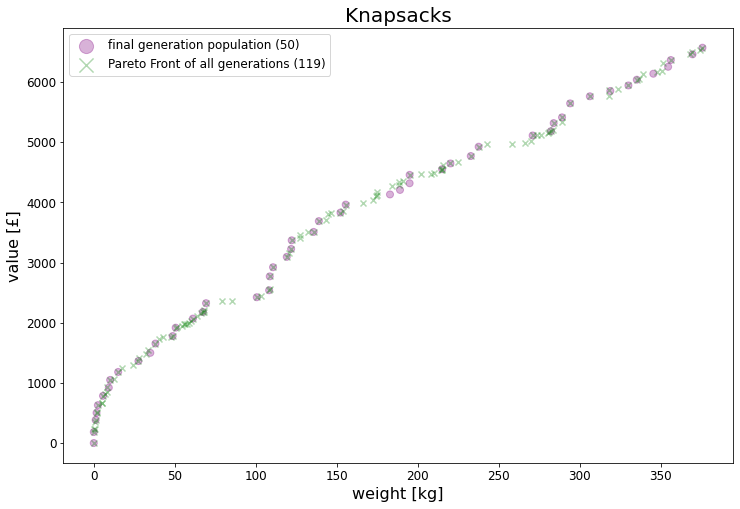

In [31]:
marker_size = 50 * df_population["counts"]
plt.scatter(df_population["weight"], df_population["value"], s=marker_size, alpha=0.3, color="purple", label=f"final generation population ({len(df_population):,})")
plt.scatter(df_hof["weight"], df_hof["value"], marker="x", alpha=0.3, color="green", label=f"Pareto Front of all generations ({len(df_hof):,})")
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [200]
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')

# All Generation Hack

The previous run gave us a lot of information, but we can extract more - 
information on all generations. 

This might be useful to 

* Improve diversity by identifying when and how they arise  
* Examine all solutions by each generation (make nice animations ;-) )


In `genetic_algorithm` you'll notice the `hack` keyword which we used as `False`.  

To obtain the full information we will hack `eaMuPlusLambda` below as `eaMuPlusLambda_hack`, 
where we introduce the `all_generations` dictionary.

We also show (but do not modify) the `varOr` function that is used.

[source code in github](https://github.com/DEAP/deap/blob/master/deap/algorithms.py)

In [32]:
def varOr(population, toolbox, lambda_, cxpb, mutpb):
    """Part of an evolutionary algorithm applying only the variation part
    (crossover, mutation **or** reproduction). The modified individuals have
    their fitness invalidated. The individuals are cloned so returned
    population is independent of the input population.
    :param population: A list of individuals to vary.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param lambda\_: The number of children to produce
    :param cxpb: The probability of mating two individuals.
    :param mutpb: The probability of mutating an individual.
    :returns: The final population.
    The variation goes as follow. On each of the *lambda_* iteration, it
    selects one of the three operations; crossover, mutation or reproduction.
    In the case of a crossover, two individuals are selected at random from
    the parental population :math:`P_\mathrm{p}`, those individuals are cloned
    using the :meth:`toolbox.clone` method and then mated using the
    :meth:`toolbox.mate` method. Only the first child is appended to the
    offspring population :math:`P_\mathrm{o}`, the second child is discarded.
    In the case of a mutation, one individual is selected at random from
    :math:`P_\mathrm{p}`, it is cloned and then mutated using using the
    :meth:`toolbox.mutate` method. The resulting mutant is appended to
    :math:`P_\mathrm{o}`. In the case of a reproduction, one individual is
    selected at random from :math:`P_\mathrm{p}`, cloned and appended to
    :math:`P_\mathrm{o}`.
    This variation is named *Or* because an offspring will never result from
    both operations crossover and mutation. The sum of both probabilities
    shall be in :math:`[0, 1]`, the reproduction probability is
    1 - *cxpb* - *mutpb*.
    """
    assert (cxpb + mutpb) <= 1.0, (
        "The sum of the crossover and mutation probabilities must be smaller "
        "or equal to 1.0.")

    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = map(toolbox.clone, random.sample(population, 2))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(random.choice(population))

    return offspring

In [33]:
from deap.tools import Logbook

def eaMuPlusLambda_hack(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    """This is the :math:`(\mu + \lambda)` evolutionary algorithm.
    :param population: A list of individuals.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param mu: The number of individuals to select for the next generation.
    :param lambda\_: The number of children to produce at each generation.
    :param cxpb: The probability that an offspring is produced by crossover.
    :param mutpb: The probability that an offspring is produced by mutation.
    :param ngen: The number of generation.
    :param stats: A :class:`~deap.tools.Statistics` object that is updated
                  inplace, optional.
    :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                       contain the best individuals, optional.
    :param verbose: Whether or not to log the statistics.
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution.
    The algorithm takes in a population and evolves it in place using the
    :func:`varOr` function. It returns the optimized population and a
    :class:`~deap.tools.Logbook` with the statistics of the evolution. The
    logbook will contain the generation number, the number of evaluations for
    each generation and the statistics if a :class:`~deap.tools.Statistics` is
    given as argument. The *cxpb* and *mutpb* arguments are passed to the
    :func:`varOr` function. The pseudocode goes as follow ::
        evaluate(population)
        for g in range(ngen):
            offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)
            evaluate(offspring)
            population = select(population + offspring, mu)
    First, the individuals having an invalid fitness are evaluated. Second,
    the evolutionary loop begins by producing *lambda_* offspring from the
    population, the offspring are generated by the :func:`varOr` function. The
    offspring are then evaluated and the next generation population is
    selected from both the offspring **and** the population. Finally, when
    *ngen* generations are done, the algorithm returns a tuple with the final
    population and a :class:`~deap.tools.Logbook` of the evolution.
    This function expects :meth:`toolbox.mate`, :meth:`toolbox.mutate`,
    :meth:`toolbox.select` and :meth:`toolbox.evaluate` aliases to be
    registered in the toolbox. This algorithm uses the :func:`varOr`
    variation.
    """
    logbook = Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
        
    # --- Hack ---
    all_generations = {}
    # ------------

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)
            
        # --- Hack ---
        all_generations[gen] = population + offspring
        # ------------

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)
        

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook, all_generations

In [34]:
pop, stats, hof, logbook, all_generations = genetic_algorithm(hack=True)

In [35]:
# Similar to before ...

print("statistics of the last generation population")
stats.compile(pop)

statistics of the last generation population


{'avg': array([ 163.69563588, 3372.95221131]),
 'std': array([ 156.285263  , 1977.92628529]),
 'min': array([0., 0.]),
 'max': array([ 509.09463269, 6587.11845137])}

In [36]:
# We can know explore the diversity of each generation

generation = 3
population_df(all_generations[generation])["counts"].value_counts()

1     50
2      1
3      1
95     1
Name: counts, dtype: int64

We can now visualise each generation 

The marker size indicates the number of solutions with the same objective values.

We can clearly see the learning from the first generation to the `NGEN`.

Text(0.5, 1.0, 'Knapsacks')

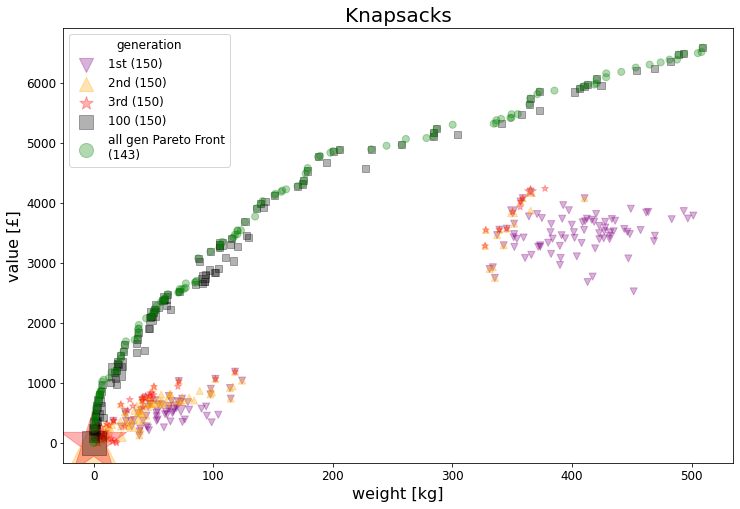

In [37]:
scatter_pop(all_generations[1], color="purple",  marker="v", label=f"1st ({len(all_generations[1]):,})")
scatter_pop(all_generations[2], color="orange", marker="^", label=f"2nd ({len(all_generations[2]):,})")
scatter_pop(all_generations[3], color="red", marker="*", label=f"3rd ({len(all_generations[2]):,})")
scatter_pop(all_generations[NGEN], color="black", marker="s", label=f"{NGEN} ({len(all_generations[NGEN]):,})")
scatter_pop(hof, color="green", label=f"all gen Pareto Front\n({len(hof):,})")
lgnd = plt.legend(title="generation")
for handle in lgnd.legendHandles:
    handle._sizes = [200]
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Knapsacks')

# References
* [DEAP ga_knapsack](https://deap.readthedocs.io/en/master/examples/ga_knapsack.html)
* [DEAP `creator`](https://deap.readthedocs.io/en/master/api/creator.html?highlight=creator)
* [DEAP `base.Toolbox.register`](https://deap.readthedocs.io/en/master/api/base.html?highlight=register#deap.base.Toolbox.register)